## Building Models

### Imports and Defaults

In [42]:
import pandas                as pd
import numpy                 as np
import tensorflow            as tf
import lightgbm              as lgbm
import seaborn               as sns
import matplotlib.pyplot     as plt
import statsmodels.api       as sm
import tensorflow            as tf
import math

from statsmodels.formula.api import logit

from sklearn                 import metrics
from sklearn.metrics         import plot_confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble        import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing   import StandardScaler
from sklearn.utils           import resample 
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors       import KNeighborsClassifier

from tensorflow              import keras
from tensorflow.keras        import layers

from pylab                   import rcParams

from keras.models            import Sequential
from keras.layers            import Dense

from datetime                import datetime
from datetime                import timedelta

import os 

%matplotlib inline
rcParams['figure.figsize']  = 15, 10
rcParams['axes.titlesize']  = 20
rcParams['axes.labelsize']  = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size']       = 18

import warnings
warnings.filterwarnings("ignore")

### Functions

In [43]:
def roundTime(dt=datetime.now(), roundTo=60):
   
   seconds  = (dt.replace(tzinfo=None) - dt.min).seconds
   rounding = (seconds+roundTo/2) // roundTo * roundTo

   return dt + timedelta(0,rounding-seconds,-dt.microsecond)

In [44]:
def saveTextFile(path, text):
    textFile = open(path, "w")
    textFile.write(text)
    textFile.close()

In [45]:
def create_downsample(training_df, features, target_variable, ratio_of_majority_to_minority, repl=False):

    df = training_df[[target_variable] + features]
    
    negative = df[df[target_variable]==0]
    positive = df[df[target_variable]==1]

    negative_downsampled = resample(negative,
                                replace = repl, # sample without replacement
                                n_samples = len(positive)*ratio_of_majority_to_minority, 
                                random_state = 0, stratify=negative['Document']) 

    downsampled = pd.concat([negative_downsampled, positive])
    
    print(downsampled[target_variable].value_counts())
                      
    return downsampled

In [46]:
def cross_validation_with_downsample(training_df, splits, features, target_variable, ratio_of_majority_to_minority, model):
    state = 9999
    df    = training_df[[target_variable]+features]
    y     = np.array(df[target_variable])
    X     = np.array(df[features])   
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        

        df2 = pd.DataFrame(X_train, columns=features)
        df2[target_variable] = y_train
            
        negative = df2[df2[target_variable]==0]
        positive = df2[df2[target_variable]==1]

        try:
            negative_downsampled = resample(negative,
                                    replace = False, # sample without replacement
                                    n_samples = len(positive)*ratio_of_majority_to_minority, 
                                    random_state=state) 
        except:
            negative_downsampled = resample(negative,
                                    replace = True, # sample without replacement
                                    n_samples = len(positive)*ratio_of_majority_to_minority, 
                                    random_state=state) 
            
        downsampled = pd.concat([negative_downsampled, positive])
        
        y_train = np.array(downsampled[target_variable])
        X_train = np.array(downsampled[features])
    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

In [47]:
def cross_validation_no_downsample(training_df, splits, features, target_variable, model):
    state = 9999
    df = training_df[[target_variable]+features]
    y = np.array(df[target_variable])
    X = np.array(df[features])
    
    skf = StratifiedKFold(n_splits=splits, 
               shuffle=True, random_state=state
              )
    skf.get_n_splits(X, y) 
    
    precision = []
    recall = []
    f1 = []
    support = []
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        if model == 'lgbm':
            clf = lgbm.LGBMClassifier(random_state=state)
        elif model == 'RandomForest':
            clf = RandomForestClassifier(random_state=state)
        elif model == 'ExtraTrees':
            clf = ExtraTreesClassifier(random_state=state)
            
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        
        
        metric_array = metrics.precision_recall_fscore_support(y_test, y_pred, average='binary')[0:3]
        precision.append(metric_array[0])
        recall.append(metric_array[1])
        f1.append(metric_array[2])
    
    stats = {'Precision': precision, 'Recall':recall,'F1':f1,}
    
    cross_val_df = pd.DataFrame(stats)
    cross_val_df.index.name='Fold'
    cross_val_df = cross_val_df.transpose()
    cross_val_df['Cross-Val Mean'] = cross_val_df.apply(np.mean, axis = 1)

    return cross_val_df

## Pretraining heatmap and data processing

Set directory


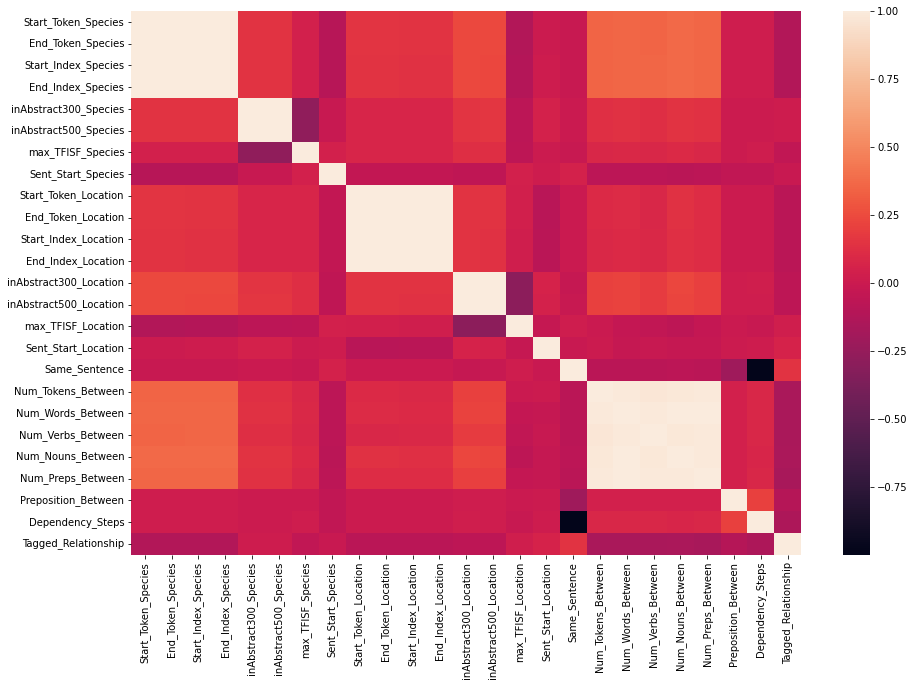

In [48]:
# Load data
relations                  = pd.read_csv('Metrics\\DataSet\\workingDataset.csv', index_col=0, dtype={'Tagged_Relationship': 'int8'})
col_to_downcast            = [col for col in relations.columns if relations[col].dtype==int]
relations[col_to_downcast] = relations[col_to_downcast].apply(pd.to_numeric, downcast='integer')

cols            = list(relations.columns)
cols.remove('Tagged_Relationship')
cols.append('Tagged_Relationship')
relations       = relations[cols]

# Directory information
print('Set directory')
date      = datetime.now()
day, time = str(roundTime(date, 10*60)).split(' ')
rootDir   = 'Results\\' + day 
rootDir   = rootDir + '\\' + next(os.walk(rootDir))[1][-1]

# Set specific folders
featuresFolder  = rootDir + '\\Features'
confusionFolder = rootDir + '\\ConfusionMatrices'
metricsFolder   = rootDir + '\\IndividualMetrics'
resultsFolder   = rootDir + '\\Results'
graphsFolder    = rootDir + '\\Graphs'
GISFolder       = rootDir + '\\GISPaper'

# Create the directories
for folder in [featuresFolder,confusionFolder,metricsFolder,resultsFolder,graphsFolder, GISFolder]:
    if not os.path.exists(folder):
        os.makedirs(folder)
        
# Heatmap of features
corr = relations.corr()
heatmap = sns.heatmap(corr)
heatmap.figure.savefig(featuresFolder + '\\HeatMap.png')

# Pre training data manipulation
features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps',
                'sqrt_max_TFISF_Species', 
                'sqrt_max_TFISF_Location',
                'sqrt_Num_Tokens_Between', 
                'sqrt_Num_Words_Between',
                'sqrt_Num_Verbs_Between', 
                'sqrt_Num_Nouns_Between',
                'sqrt_Num_Preps_Between', 
                'log_max_TFISF_Species',
                'log_max_TFISF_Location', 
                'log_Num_Verbs_Between']

features_all = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'max_TFISF_Species',
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location',
                'max_TFISF_Location', 
                'Sent_Start_Location', 
                'Same_Sentence',
                'Num_Tokens_Between', 
                'Num_Words_Between', 
                'Num_Verbs_Between',
                'Num_Nouns_Between',
                'Num_Preps_Between', 
                'Preposition_Between',
                'Dependency_Steps']

features_cat = ['inAbstract300_Species', 
                'inAbstract500_Species', 
                'Sent_Start_Species', 
                'inAbstract300_Location', 
                'inAbstract500_Location', 
                'Sent_Start_Location', 
                'Same_Sentence', 
                'Preposition_Between']

features_raw = features_all[:16]

y = relations.Tagged_Relationship

X = relations[features_all]

sqrt_max_TFISF_Species               = [math.sqrt(x) for x in relations['max_TFISF_Species']]
relations['sqrt_max_TFISF_Species']  = sqrt_max_TFISF_Species

sqrt_max_TFISF_Location              = [math.sqrt(x) for x in relations['max_TFISF_Location']]
relations['sqrt_max_TFISF_Location'] = sqrt_max_TFISF_Location

sqrt_Num_Tokens_Between              = [math.sqrt(x) for x in relations['Num_Tokens_Between']]
relations['sqrt_Num_Tokens_Between'] = sqrt_Num_Tokens_Between

sqrt_Num_Words_Between               = [math.sqrt(x) for x in relations['Num_Words_Between']]
relations['sqrt_Num_Words_Between']  = sqrt_Num_Words_Between

sqrt_Num_Verbs_Between               = [math.sqrt(x) for x in relations['Num_Verbs_Between']]
relations['sqrt_Num_Verbs_Between']  = sqrt_Num_Verbs_Between

sqrt_Num_Nouns_Between               = [math.sqrt(x) for x in relations['Num_Nouns_Between']]
relations['sqrt_Num_Nouns_Between']  = sqrt_Num_Nouns_Between

sqrt_Num_Preps_Between               = [math.sqrt(x) for x in relations['Num_Preps_Between']]
relations['sqrt_Num_Preps_Between']  = sqrt_Num_Preps_Between

log_max_TFISF_Species                = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Species']]
relations['log_max_TFISF_Species']   = log_max_TFISF_Species

log_max_TFISF_Location               = [math.log(x) if x > 0 else 0 for x in relations['max_TFISF_Location']]
relations['log_max_TFISF_Location']  = log_max_TFISF_Location

log_Num_Verbs_Between                = [math.log(x) if x > 0 else 0 for x in relations['Num_Verbs_Between']]
relations['log_Num_Verbs_Between']   = log_Num_Verbs_Between

x = relations[features_all + ['Document', 'Tagged_Relationship']]

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    x['Tagged_Relationship'], 
                                                    test_size    = 0.3,
                                                    random_state = 0, 
                                                    shuffle      = True,
                                                    stratify     = x[['Document', 'Tagged_Relationship']])
train                = x_train.copy()
x_train.drop(columns = ['Document', 'Tagged_Relationship'], inplace=True)
x_test_with_document = x_test.copy()
x_test.drop(columns  = ['Document', 'Tagged_Relationship'], inplace=True)

## Models

### Adaboost

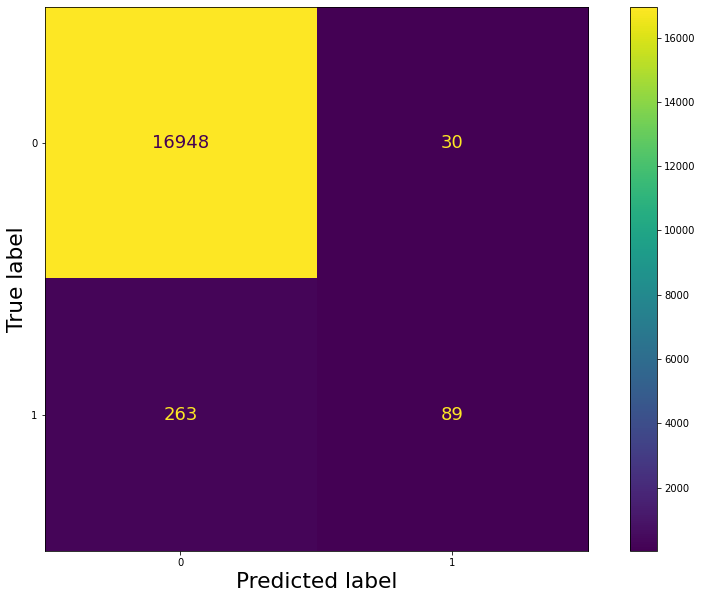

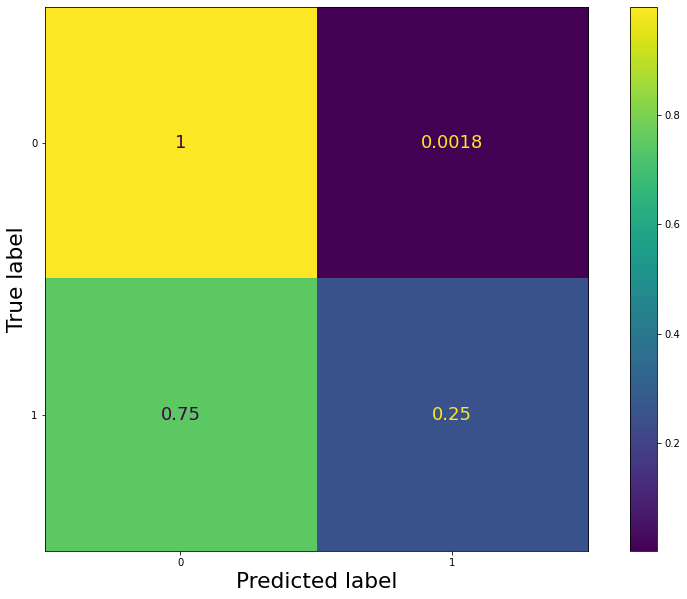

In [49]:
adaboost_clf    = AdaBoostClassifier(random_state=0)
adaboost_clf.fit(x_train[features_raw], y_train)
y_pred_adaboost = adaboost_clf.predict(x_test[features_raw])

# Metrics
saveTextFile(metricsFolder + '\\AdaBoost.txt', metrics.classification_report(y_test, y_pred_adaboost))

# First confusion Matrix
confusionMatrix = plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\AdaBoost01.png')

# Second confusion matrix
confusionMatrix = plot_confusion_matrix(adaboost_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\AdaBoost02.png')

# Feature importance table
pd.DataFrame(sorted(list(zip(features_raw, adaboost_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns = ['Feature', 'Importance'])

# Top features list
top_abst_features    = list(pd.DataFrame(sorted(list(zip(features_all, adaboost_clf.feature_importances_)), 
                            key     = lambda x:x[1], 
                            reverse = True), 
                            columns = ['Feature', 'Importance'])['Feature'][:10])

### Light Gradient Boosting Machine (LGBM)

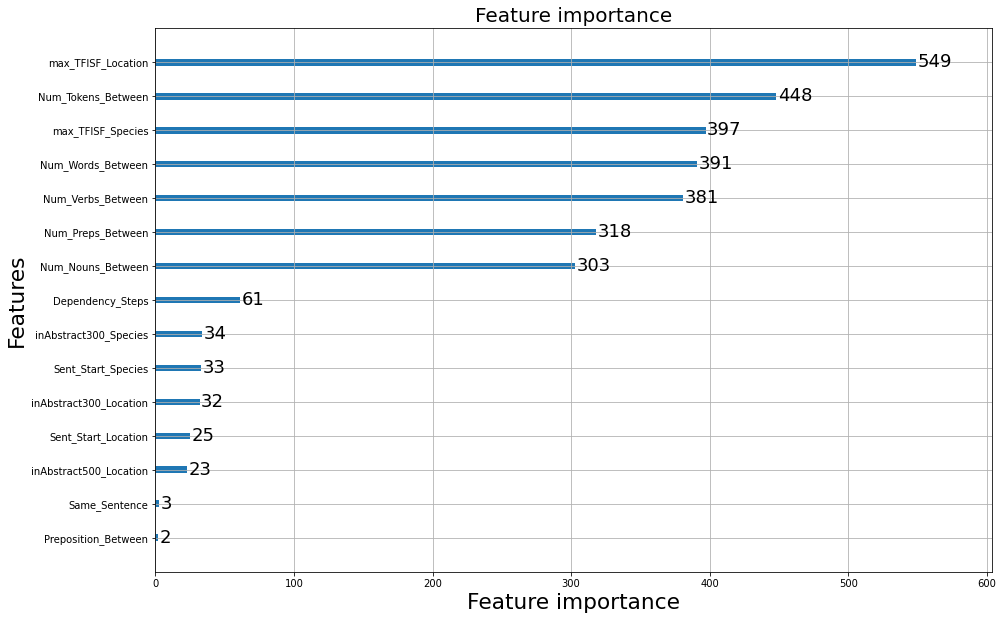

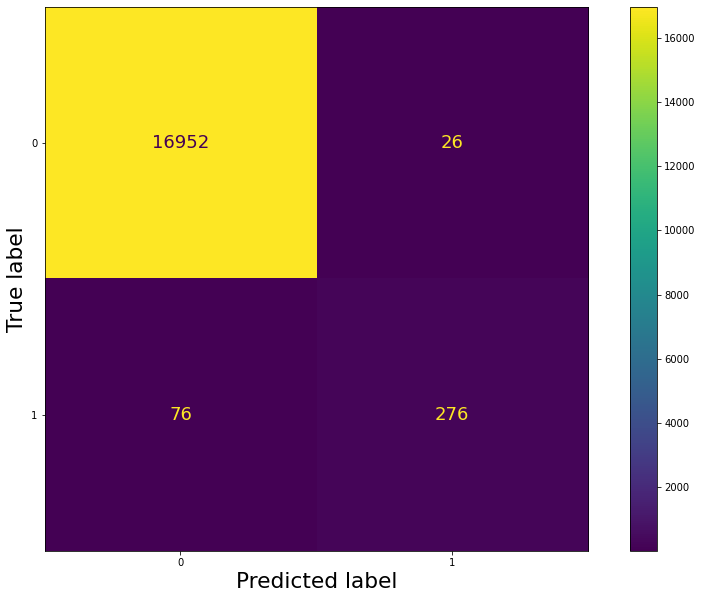

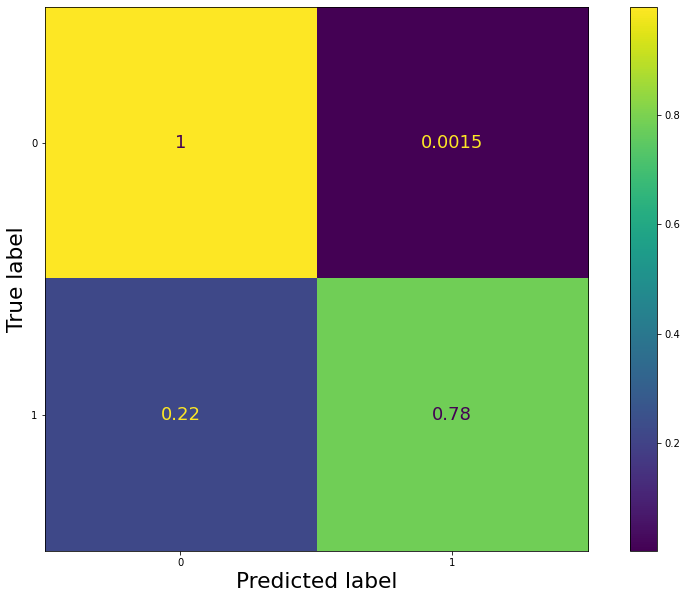

In [50]:
lgbm_clf = lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)

# Feature importance image
lgbm.plot_importance(lgbm_clf)

# Feature importance table
lgbm_feat_imp = pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])
lgbm_feat_imp['Normalised']= lgbm_feat_imp.Importance / lgbm_feat_imp.Importance.sum() 
lgbm_feat_imp

# Top feature importance printout
top_lgbm_features = list(pd.DataFrame(sorted(list(zip(features_raw, lgbm_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:14])
top_lgbm_features

# LGBM Metrics
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\LGBM.txt', metrics.classification_report(y_test, y_pred_lgbm))

# Confusion matrix 
confusionMatrix = plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\LGBM01.png')

# Second confusion matrix
confusionMatrix = plot_confusion_matrix(lgbm_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\LGBM02.png')

### Random Forest Classifier

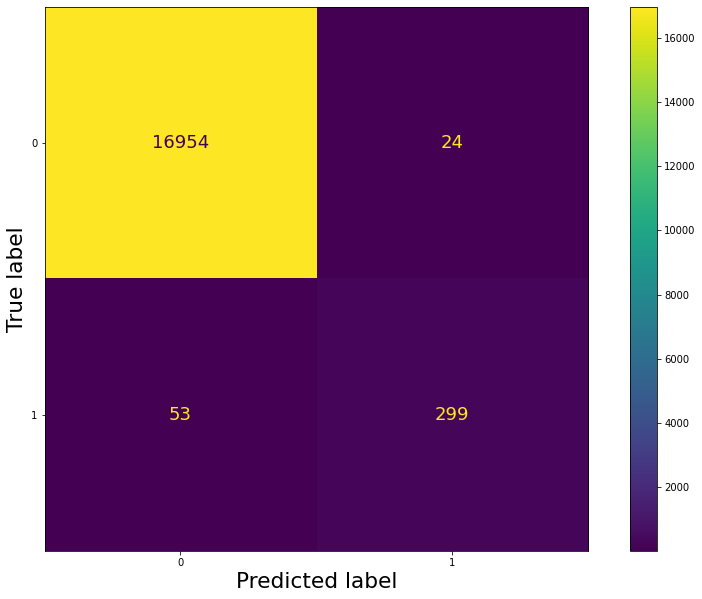

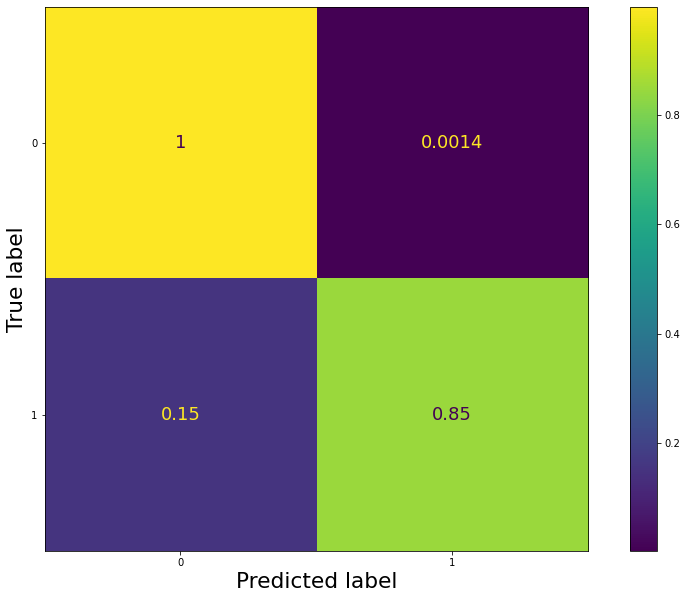

In [51]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)

# Geature importance table
pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

# Top features list
top_rf_features = list(pd.DataFrame(sorted(list(zip(features_raw, rf_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])

# Metrics
y_pred_rf = rf_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\RandomForest.txt', metrics.classification_report(y_test, y_pred_rf))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(rf_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\RandomForest01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(rf_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\RandomForest02.png')

### Extra Randomised Trees

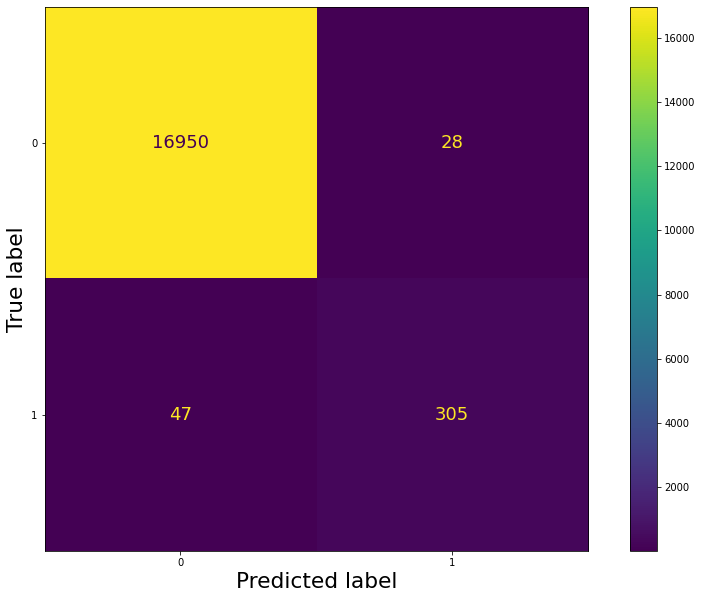

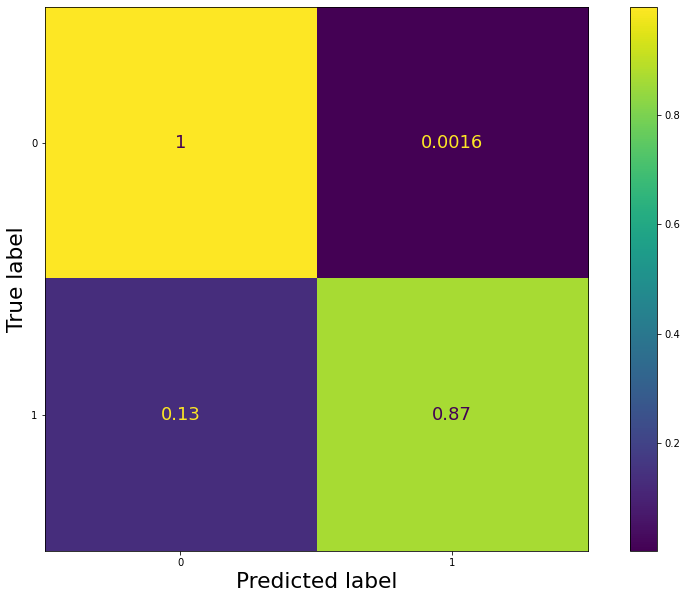

In [52]:
xt_clf = ExtraTreesClassifier(random_state=0)
xt_clf.fit(x_train[features_raw], y_train)

# Feature Importance table
pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])

# Top features list
top_et_features = list(pd.DataFrame(sorted(list(zip(features_raw, xt_clf.feature_importances_)), key = lambda x:x[1], reverse = True), 
             columns=['Feature', 'Importance'])['Feature'][:10])

# Metrics
y_pred_xt = xt_clf.predict(x_test[features_raw])
saveTextFile(metricsFolder + '\\ExtraRandomizedTrees.txt', metrics.classification_report(y_test, y_pred_xt))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(xt_clf, x_test[features_raw], y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\ExtraRandomizedTrees01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(xt_clf, x_test[features_raw], y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\ExtraRandomizedTrees02.png')

### Logistic Regression

Optimization terminated successfully.
         Current function value: 0.064753
         Iterations 17
                            Logit Regression Results                           
Dep. Variable:     Tagged_Relationship   No. Observations:                40435
Model:                           Logit   Df Residuals:                    40425
Method:                            MLE   Df Model:                            9
Date:                 Tue, 25 Jan 2022   Pseudo R-squ.:                  0.3493
Time:                         09:05:28   Log-Likelihood:                -2618.3
converged:                        True   LL-Null:                       -4023.6
Covariance Type:             nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -23.7206     98.683     -0.240      0.810    -217.136     1

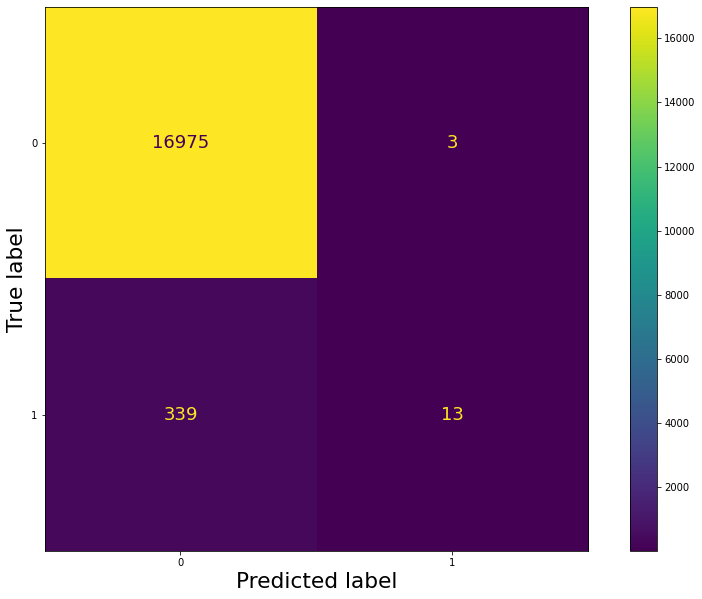

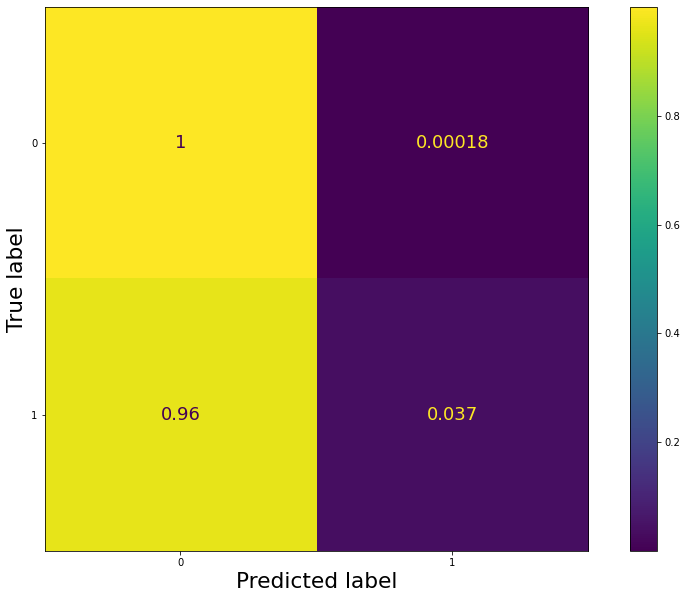

In [53]:
logReg_clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='')
logReg_clf.fit(x_train[features_all], y_train)

# Metrics
y_pred_logReg = logReg_clf.predict(x_test[features_all])
saveTextFile(metricsFolder + '\\LogisticRegression01.txt', metrics.classification_report(y_test, y_pred_logReg))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(logReg_clf, x_test, y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\LogisticRegression01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(logReg_clf, x_test, y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\LogisticRegression02.png')

# Extra training for Log Reg
feats_logReg = features_all.copy()
for item in ['inAbstract300_Species', 
             'inAbstract500_Species',  
             'inAbstract300_Location',
             'inAbstract500_Location', 
             'sqrt_Num_Tokens_Between', 
             'Preposition_Between', 
             'sqrt_max_TFISF_Species',
            'log_max_TFISF_Species', 
             'Sent_Start_Species',
             'sqrt_Num_Verbs_Between',
             'max_TFISF_Species',
             'log_Num_Verbs_Between',
             'sqrt_Num_Nouns_Between']:
    
    if item in feats_logReg:
        feats_logReg.remove(item)
    
logReg_mod_formula = "Tagged_Relationship ~ "

for feat in feats_logReg[:-1]:
    logReg_mod_formula = logReg_mod_formula + feat + ' + '
    
logReg_mod_formula = logReg_mod_formula + feats_logReg[-1]

pd.concat([x_train, y_train], axis=1)
    
logReg_mod = logit(logReg_mod_formula, pd.concat([x_train, y_train], axis=1)).fit()

# Summary
print(logReg_mod.summary())

y_pred_logReg2       = logReg_mod.predict(x_test)
y_pred_logReg2_round = np.round(y_pred_logReg2)

# New metrics
saveTextFile(metricsFolder + '\\LogisticRegression02.txt', metrics.classification_report(y_test, y_pred_logReg2_round))

combinedFeats = list(set(top_abst_features+ top_et_features+ top_lgbm_features+ top_rf_features))


### Neural Network

In [54]:
y_test_NN      = np.ravel(y_test)
y_train_NN     = np.ravel(y_train)
scaler         = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled  = scaler.transform(x_test)  
model          = Sequential()

model.add(Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
              optimizer='sgd',
              metrics=[tf.keras.metrics.Recall()]
)

model.fit(x_train_scaled, y_train_NN, epochs=20, 
          batch_size=32, 
          verbose=1
         )

predict_x = model.predict(x_test_scaled) 
y_pred_NN = np.argmax(predict_x,axis=1)

# Save metrics
saveTextFile(metricsFolder + '\\NeuralNetwork.txt', metrics.classification_report(y_test, y_pred_NN))

Epoch 1/20
1264/1264 [==============================] - 2s 898us/step - loss: 0.1263 - recall_1: 0.0109
Epoch 2/20
1264/1264 [==============================] - 1s 768us/step - loss: 0.0814 - recall_1: 0.0255
Epoch 3/20
1264/1264 [==============================] - 1s 804us/step - loss: 0.0744 - recall_1: 0.0316
Epoch 4/20
1264/1264 [==============================] - 1s 776us/step - loss: 0.0703 - recall_1: 0.0376
Epoch 5/20
1264/1264 [==============================] - 1s 772us/step - loss: 0.0679 - recall_1: 0.0340
Epoch 6/20
1264/1264 [==============================] - 1s 776us/step - loss: 0.0660 - recall_1: 0.0376
Epoch 7/20
1264/1264 [==============================] - 1s 783us/step - loss: 0.0648 - recall_1: 0.0413
Epoch 8/20
1264/1264 [==============================] - 1s 810us/step - loss: 0.0636 - recall_1: 0.0485
Epoch 9/20
1264/1264 [==============================] - 1s 748us/step - loss: 0.0629 - recall_1: 0.0570
Epoch 10/20
1264/1264 [==============================] - 1s 739u

### kNN

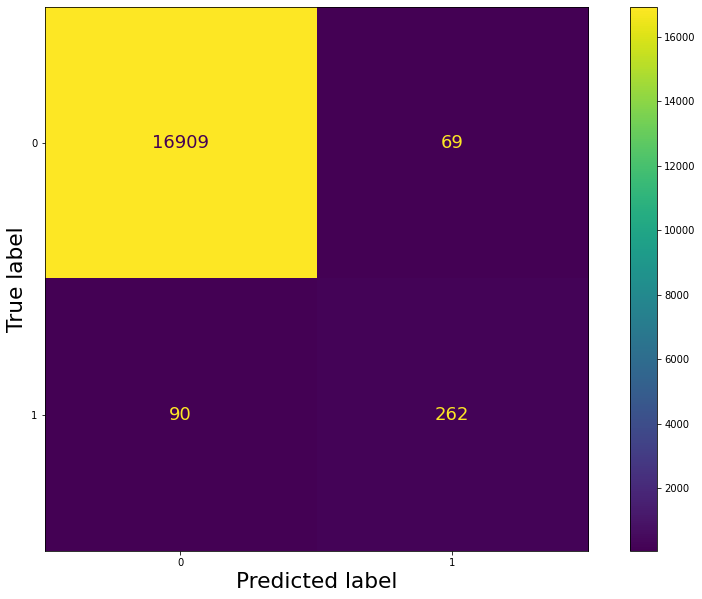

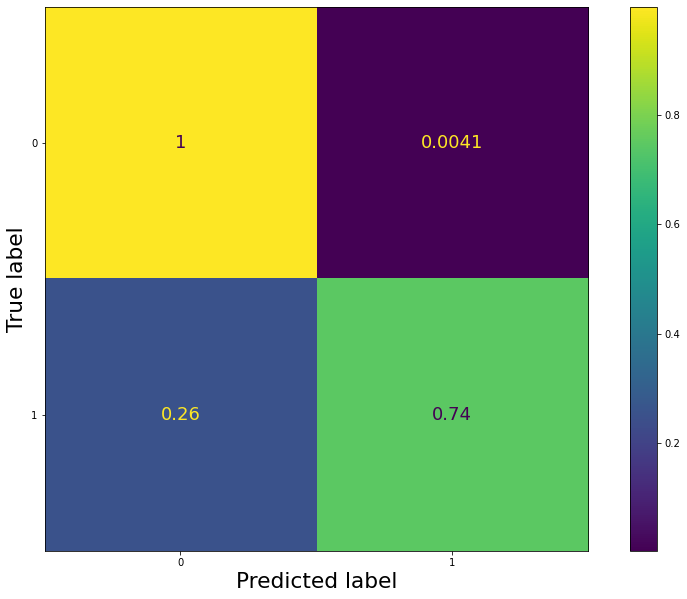

In [55]:
scaler         = StandardScaler().fit(x_train[features_raw])
x_train_scaled = scaler.transform(x_train[features_raw])
x_test_scaled  = scaler.transform(x_test[features_raw])  
knn_clf        = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train_scaled, y_train)
y_pred_knn     = knn_clf.predict(x_test_scaled)

# Metrics
saveTextFile(metricsFolder + '\\kNN.txt', metrics.classification_report(y_test, y_pred_knn))

# Confusion Matrix 01
confusionMatrix = plot_confusion_matrix(knn_clf, x_test_scaled, y_test)
confusionMatrix.figure_.savefig(confusionFolder + '\\kNN01.png')

# Confusion Matrix 02
confusionMatrix = plot_confusion_matrix(knn_clf, x_test_scaled, y_test, normalize='true')
confusionMatrix.figure_.savefig(confusionFolder + '\\kNN02.png')

## Downsampling

0    824
1    824
Name: Tagged_Relationship, dtype: int64
0    1648
1     824
Name: Tagged_Relationship, dtype: int64
0    4120
1     824
Name: Tagged_Relationship, dtype: int64
0    8240
1     824
Name: Tagged_Relationship, dtype: int64
0    41200
1      824
Name: Tagged_Relationship, dtype: int64
0    82400
1      824
Name: Tagged_Relationship, dtype: int64


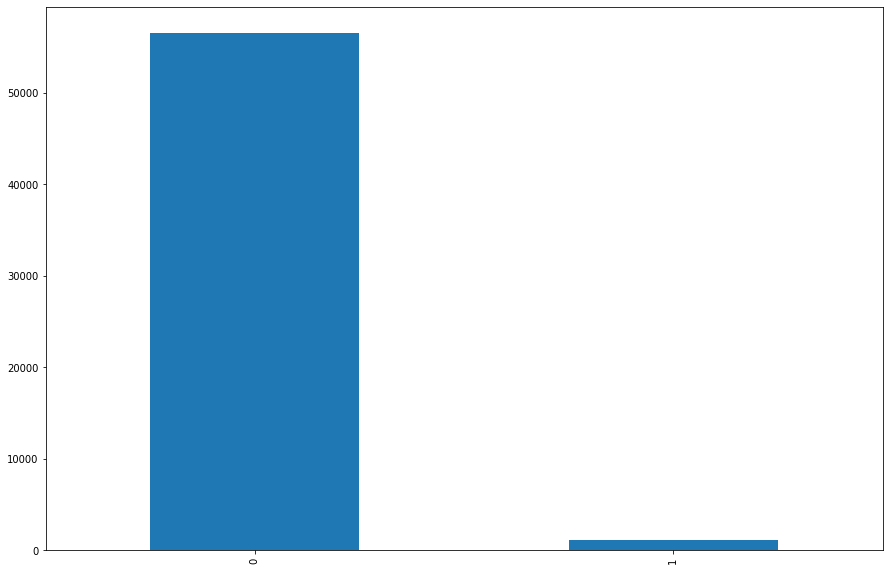

In [56]:
# Relationship ratios
string =  'Actual Relationships: '  + str(relations['Tagged_Relationship'].value_counts()[1]) 
string += '\nNot Relationships: '    + str(relations['Tagged_Relationship'].value_counts()[0])
string += '\nRatio of non to true: ' + str(int(relations['Tagged_Relationship'].value_counts()[0]/relations['Tagged_Relationship'].value_counts()[1]))
string += ':1'
saveTextFile(resultsFolder + '\\RelationshipToNonRelationship.txt', string)

relations['Tagged_Relationship'].value_counts().plot.bar()

# First Downsample
downsample1to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 1)
downsample2to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 2)
downsample5to1   = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 5)
downsample10to1  = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 10)
downsample50to1  = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 50, True)
downsample100to1 = create_downsample(train, features_all+['Document'], 'Tagged_Relationship', 100, True)
downsamples      = [downsample100to1, downsample50to1, downsample10to1, downsample5to1, downsample2to1]
samplenames      = ['downsample100to1', 'downsample50to1', 'downsample10to1', 'downsample5to1', 'downsample2to1']

model     = []
sample    = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Random Forest - '+ name)
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))
    
model     = []
sampling  = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM')
sampling.append('Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[features_raw], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM')
    sampling.append(name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[features_raw])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees')
sampling.append('Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[features_raw], y_train)
y_pred_et = et_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees')
    sampling.append(name)
    
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[features_raw])


    
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest')
sampling.append('Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[features_raw], y_train)
y_pred_rf = rf_clf.predict(x_test[features_raw])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[features_raw]
    ds_y_train = sample['Tagged_Relationship']

    
    model.append('Random Forest')
    sampling.append(name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[features_raw], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[features_raw])

    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))
    
# Out the First results
pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample01.csv')

# Second Down Sample
model     = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)

    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_lgbm_features])
    
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_et = et_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Extra Trees - '+ name)

    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_lgbm_features])

    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_lgbm_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_lgbm_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_lgbm_features]
    ds_y_train = sample['Tagged_Relationship']
    
    
    model.append('Random Forest - '+ name)

    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_lgbm_features], ds_y_train)

    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_lgbm_features])
    
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

# Out the second results
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample02.csv')

# Top Features
top_tree_features = top_lgbm_features[:13]

# Third Downsample
model     = []
Precision = []
Recall    = []
F1        = []

model.append('LGBM - Full Train Sample')
lgbm_clf =lgbm.LGBMClassifier(random_state=0)
lgbm_clf.fit(x_train[top_tree_features], y_train)
y_pred_lgbm = lgbm_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_lgbm))
Recall.append(metrics.recall_score(y_test, y_pred_lgbm))
Precision.append(metrics.precision_score(y_test, y_pred_lgbm))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']

    model.append('LGBM-'+name)
    ds_lgbm_clf = lgbm.LGBMClassifier(random_state=0)
    ds_lgbm_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_lgbm_test = ds_lgbm_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_lgbm_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_lgbm_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_lgbm_test))
    
model.append('Extra Trees - Full Train Sample')
et_clf =lgbm.LGBMClassifier(random_state=0)
et_clf.fit(x_train[top_tree_features], y_train)
y_pred_et = et_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_et))
Recall.append(metrics.recall_score(y_test, y_pred_et))
Precision.append(metrics.precision_score(y_test, y_pred_et))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    
    model.append('Extra Trees - '+ name)
    ds_et_clf = ExtraTreesClassifier(random_state=0)
    ds_et_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_et_test = ds_et_clf.predict(x_test[top_tree_features])
    F1.append(metrics.f1_score(y_test, y_pred_ds_et_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_et_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_et_test))
    
model.append('Random Forest - Full Train Sample')
rf_clf =lgbm.LGBMClassifier(random_state=0)
rf_clf.fit(x_train[top_tree_features], y_train)
y_pred_rf = rf_clf.predict(x_test[top_tree_features])
F1.append(metrics.f1_score(y_test, y_pred_rf))
Recall.append(metrics.recall_score(y_test, y_pred_rf))
Precision.append(metrics.precision_score(y_test, y_pred_rf))

for sample, name in zip(downsamples, samplenames):
    ds_x_train = sample[top_tree_features]
    ds_y_train = sample['Tagged_Relationship']
    model.append('Random Forest - '+ name)
    ds_rf_clf = ExtraTreesClassifier(random_state=0)
    ds_rf_clf.fit(ds_x_train[top_tree_features], ds_y_train)
    y_pred_ds_rf_test = ds_rf_clf.predict(x_test[top_tree_features])   
    F1.append(metrics.f1_score(y_test, y_pred_ds_rf_test))
    Recall.append(metrics.recall_score(y_test, y_pred_ds_rf_test))
    Precision.append(metrics.precision_score(y_test, y_pred_ds_rf_test))

# Out the results
pd.DataFrame({'Model':model, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False).to_csv(resultsFolder + '\\DownSample03.csv')

## Cross Validation

In [57]:
scores = cross_val_score(lgbm_clf, X, y, cv=5, scoring='f1')

print ('Relationship stats')
for source in relations.Document.unique():
    print(source, '\n',relations[relations.Document==source].Tagged_Relationship.value_counts()[1], '/', len(relations[relations.Document==source]), '\t', 
          np.round(relations[relations.Document==source].Tagged_Relationship.value_counts(normalize = True)[1],4), '\n')
    
skf = StratifiedKFold(n_splits=5, shuffle=True)

Relationship stats
10.1017_S0954102001000360.pdf 
 345 / 3077 	 0.1121 

10.1078_0031_4056_00075.pdf 
 113 / 2064 	 0.0547 

10.1078_0031_4056_00154.pdf 
 617 / 9872 	 0.0625 

s42003_018_0260_y.txt 
 5 / 3420 	 0.0015 

source.txt 
 9 / 770 	 0.0117 

summer_activity_patterns_for_mosses_and_lichens_in_maritime_antarctica.txt 
 87 / 38562 	 0.0023 



In [58]:
cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm')

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.659884,0.649573,0.616000,0.602667,0.599483,0.625521
Recall,0.965957,0.970213,0.982979,0.961702,0.983051,0.972780
F1,0.784111,0.778157,0.757377,0.740984,0.744783,0.761082


In [59]:
cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'lgbm')

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.951872,0.898148,0.903226,0.888393,0.907080,0.909744
Recall,0.757447,0.825532,0.834043,0.846809,0.868644,0.826495
F1,0.843602,0.860310,0.867257,0.867102,0.887446,0.865143


In [60]:
lgbmfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'lgbm')
lgbmfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.942308,0.879464,0.888393,0.912037,0.863636,0.897168
Recall,0.834043,0.838298,0.846809,0.838298,0.885593,0.848608
F1,0.884876,0.858388,0.867102,0.873614,0.874477,0.871691


In [61]:
lgbmfull['Cross-Val Mean'][0]

0.8971676471676473

In [62]:
try:
    lgbm50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'lgbm')
except:
    lgbm50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'lgbm', True)
lgbm50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.892377,0.910314,0.880851,0.845833,0.848101,0.875495
Recall,0.846809,0.863830,0.880851,0.863830,0.851695,0.861403
F1,0.868996,0.886463,0.880851,0.854737,0.849894,0.868188


In [63]:
try:
    lgbm20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'lgbm')
except:
    lgbm20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'lgbm', True)
lgbm20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.853175,0.794872,0.833962,0.804428,0.840149,0.825317
Recall,0.914894,0.923404,0.940426,0.927660,0.957627,0.932802
F1,0.882957,0.854331,0.884000,0.861660,0.895050,0.875599


In [64]:
try:
    lgbm10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'lgbm')
except:
    lgbm10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'lgbm', True)
lgbm10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.781690,0.745819,0.749175,0.726688,0.729299,0.746534
Recall,0.944681,0.948936,0.965957,0.961702,0.970339,0.958323
F1,0.855491,0.835206,0.843866,0.827839,0.832727,0.839026


In [65]:
try:
    lgbm5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm')
except:
    lgbm5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'lgbm', True)
lgbm5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.659884,0.649573,0.616000,0.602667,0.599483,0.625521
Recall,0.965957,0.970213,0.982979,0.961702,0.983051,0.972780
F1,0.784111,0.778157,0.757377,0.740984,0.744783,0.761082


In [66]:
lgbm2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'lgbm')
lgbm2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.471193,0.455823,0.429358,0.418478,0.395230,0.434017
Recall,0.974468,0.965957,0.995745,0.982979,0.983051,0.980440
F1,0.635229,0.619372,0.600000,0.587039,0.563791,0.601086


In [67]:
rffull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'RandomForest')
rffull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.954955,0.933921,0.93617,0.933036,0.923077,0.936232
Recall,0.902128,0.902128,0.93617,0.889362,0.915254,0.909008
F1,0.927790,0.917749,0.93617,0.910675,0.919149,0.922307


In [68]:
try:
    rf100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'RandomForest')
except:
    rf100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'RandomForest', True)
rf100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.958716,0.958525,0.935622,0.941176,0.927039,0.944216
Recall,0.889362,0.885106,0.927660,0.885106,0.915254,0.900498
F1,0.922737,0.920354,0.931624,0.912281,0.921109,0.921621


In [69]:
try:
    rf50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'RandomForest')
except:
    rf50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'RandomForest', True)
rf50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.947368,0.925764,0.921162,0.930131,0.915966,0.928078
Recall,0.919149,0.902128,0.944681,0.906383,0.923729,0.919214
F1,0.933045,0.913793,0.932773,0.918103,0.919831,0.923509


In [70]:
try:
    rf20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'RandomForest')
except:
    rf20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'RandomForest', True)
rf20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.924686,0.883534,0.878431,0.858824,0.861004,0.881296
Recall,0.940426,0.936170,0.953191,0.931915,0.944915,0.941323
F1,0.932489,0.909091,0.914286,0.893878,0.901010,0.910151


In [71]:
try:
    rf10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'RandomForest')
except:
    rf10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'RandomForest', True)
rf10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.832090,0.790941,0.791096,0.775862,0.774744,0.792946
Recall,0.948936,0.965957,0.982979,0.957447,0.961864,0.963437
F1,0.886680,0.869732,0.876660,0.857143,0.858223,0.869688


In [72]:
rf5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'RandomForest')
rf5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.703125,0.661808,0.677419,0.646893,0.632597,0.664368
Recall,0.957447,0.965957,0.982979,0.974468,0.970339,0.970238
F1,0.810811,0.785467,0.802083,0.777589,0.765886,0.788367


In [73]:
rf2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'RandomForest')
rf2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.479167,0.493534,0.468000,0.458498,0.430427,0.465925
Recall,0.978723,0.974468,0.995745,0.987234,0.983051,0.983844
F1,0.643357,0.655222,0.636735,0.626181,0.598710,0.632041


In [74]:
etfull = cross_validation_no_downsample(relations, 5, features_raw, 'Tagged_Relationship', 'ExtraTrees')
etfull

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.954751,0.925110,0.936709,0.938053,0.919831,0.934891
Recall,0.897872,0.893617,0.944681,0.902128,0.923729,0.912405
F1,0.925439,0.909091,0.940678,0.919740,0.921776,0.923345


In [75]:
try:
    et100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'ExtraTrees')
except:
    et100 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 100, 'ExtraTrees', True)
et100

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.954955,0.937500,0.932773,0.935065,0.920168,0.936092
Recall,0.902128,0.893617,0.944681,0.919149,0.927966,0.917508
F1,0.927790,0.915033,0.938689,0.927039,0.924051,0.926520


In [76]:
try:
    et50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'ExtraTrees')
except:
    et50 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 50, 'ExtraTrees', True)
et50

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.943231,0.917031,0.918367,0.931034,0.899194,0.921771
Recall,0.919149,0.893617,0.957447,0.919149,0.944915,0.926855
F1,0.931034,0.905172,0.937500,0.925054,0.921488,0.924050


In [77]:
try:
    et20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'ExtraTrees')
except:
    et20 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 20, 'ExtraTrees', True)
et20

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.901639,0.859375,0.901186,0.856031,0.847015,0.873049
Recall,0.936170,0.936170,0.970213,0.936170,0.961864,0.948118
F1,0.918580,0.896130,0.934426,0.894309,0.900794,0.908848


In [78]:
try:
    et10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'ExtraTrees')
except:
    et10 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 10, 'ExtraTrees', True)
et10

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.825926,0.798561,0.783051,0.804965,0.766667,0.795834
Recall,0.948936,0.944681,0.982979,0.965957,0.974576,0.963426
F1,0.883168,0.865497,0.871698,0.878143,0.858209,0.871343


In [79]:
et5 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 5, 'ExtraTrees')
et5

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.703470,0.691358,0.675362,0.699387,0.642659,0.682447
Recall,0.948936,0.953191,0.991489,0.970213,0.983051,0.969376
F1,0.807971,0.801431,0.803448,0.812834,0.777219,0.800581


In [80]:
et2 = cross_validation_with_downsample(relations, 5, features_raw, 'Tagged_Relationship', 2, 'ExtraTrees')
et2

Fold,0,1,2,3,4,Cross-Val Mean
Precision,0.506696,0.498906,0.486486,0.509934,0.448743,0.490153
Recall,0.965957,0.970213,0.995745,0.982979,0.983051,0.979589
F1,0.664714,0.658960,0.653631,0.671512,0.616202,0.653004


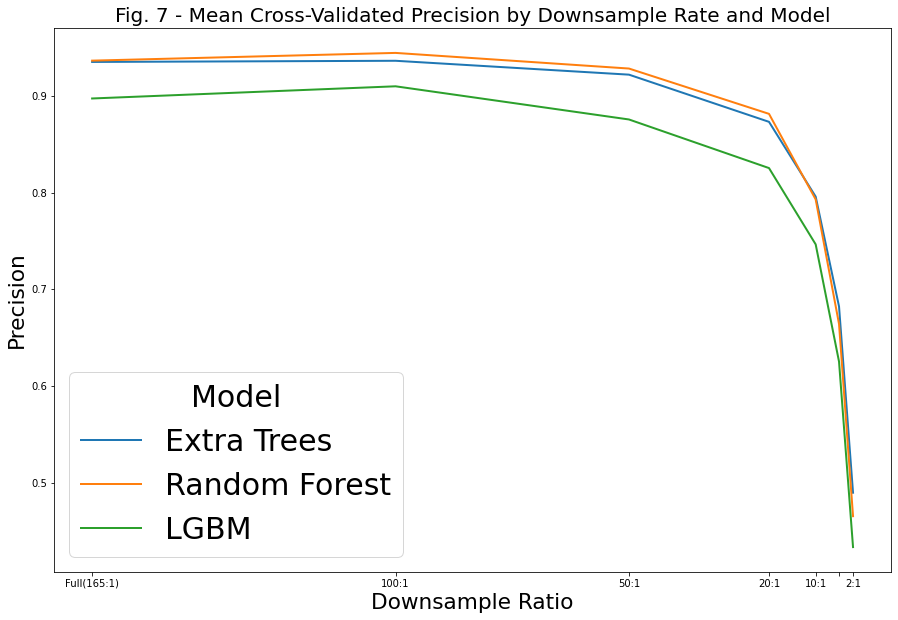

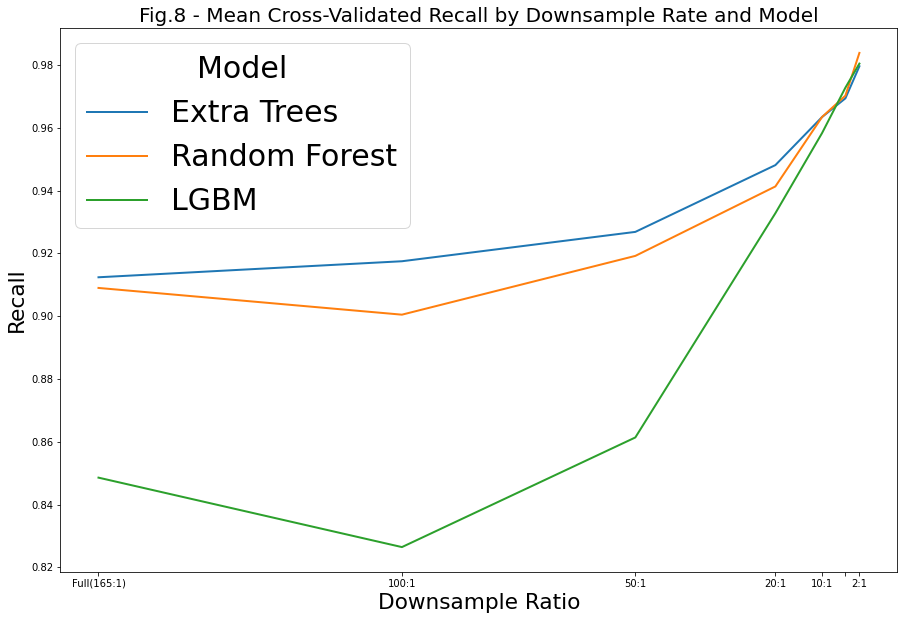

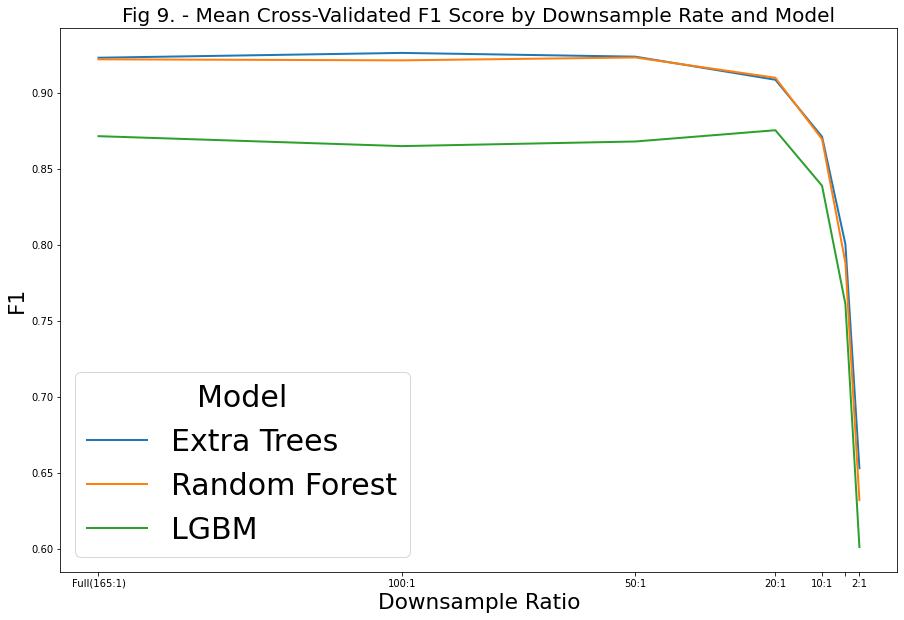

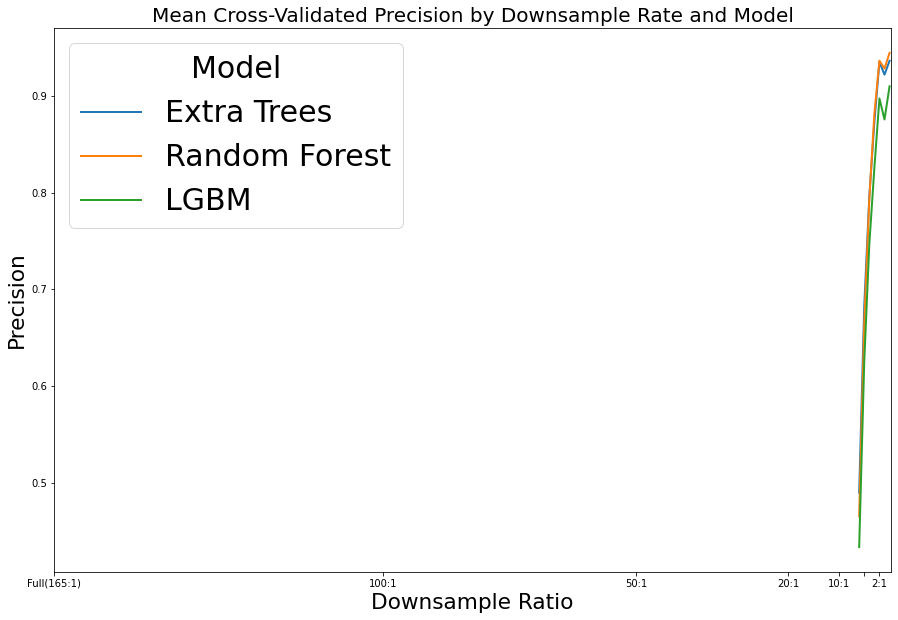

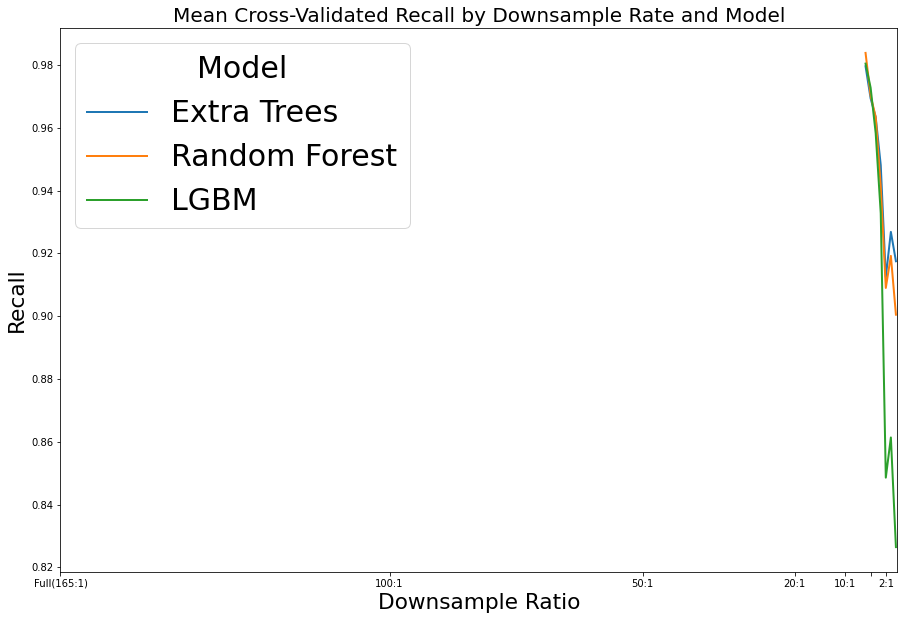

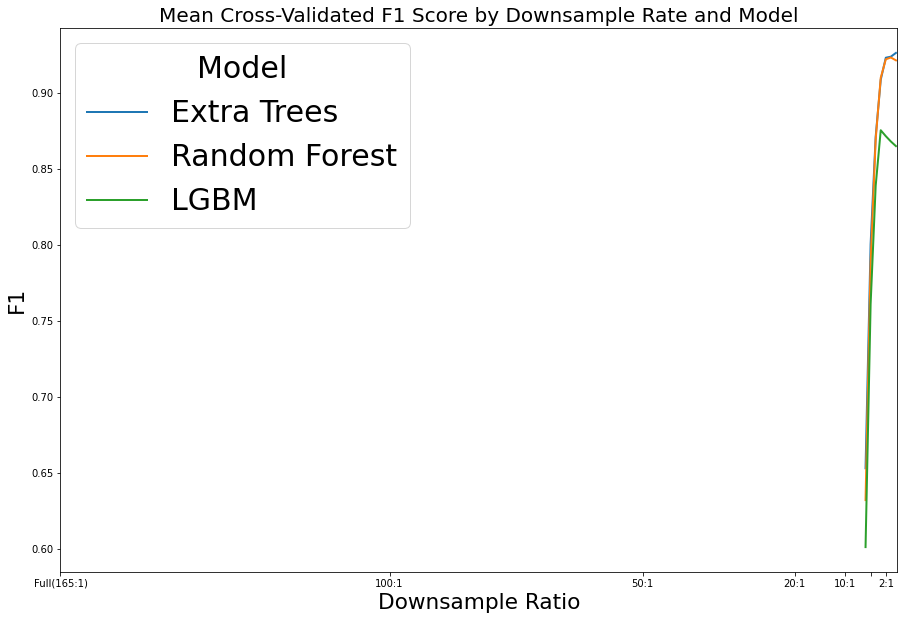

In [81]:
# Compound results to dataframe
modellist   = ['lgbm', 'RandomForest', 'ExtraTrees']
modelNames  = ['LGBM', 'Random Forest', 'Extra Trees']
downsamples = [100, 50, 20, 10, 5, 2]
model       = []
sampling    = []
Precision   = []
Recall      = []
F1          = []

for i, modeltype in enumerate(modellist):
    model.append(modelNames[i])
    sampling.append('Full Train Sample')
    try:
        results = cross_validation_no_downsample(relations,5,features_raw,'Tagged_Relationship', modeltype)
    except:
        results = cross_validation_no_downsample(relations,5,features_raw,'Tagged_Relationship', modeltype, True)
    F1.append(results['Cross-Val Mean'][2])
    Recall.append(results['Cross-Val Mean'][1])
    Precision.append(results['Cross-Val Mean'][0])
    
    for size in downsamples:
        model.append(modelNames[i])
        sampling.append('Downsample '+ str(size)+ ' to 1')
        try:
            results = cross_validation_with_downsample(relations,5,features_raw,'Tagged_Relationship', size, modeltype)
        except:
            results = cross_validation_with_downsample(relations,5,features_raw,'Tagged_Relationship', size, modeltype, True)
        F1.append(results['Cross-Val Mean'][2])
        Recall.append(results['Cross-Val Mean'][1])
        Precision.append(results['Cross-Val Mean'][0])

# First dataframe                    
crossValResults = pd.DataFrame({'Model':model, 'Sample':sampling, 'Precision': Precision, 'Recall': Recall, 'F1': F1}).sort_values('F1', ascending=False)
crossValResults.to_csv(resultsFolder + '\\CrossValidation01.csv')
crossValResults

# Second dataframe
ratio = {'Full Train Sample':165, 'Downsample 100 to 1':100, 'Downsample 50 to 1':50,
       'Downsample 20 to 1':20, 'Downsample 10 to 1':10, 'Downsample 5 to 1':5,
       'Downsample 2 to 1':2}
crossValResults['Sample Ratio'] = crossValResults['Sample'].map(ratio)
crossValResults.to_csv(resultsFolder + '\\CrossValidation02.csv')
crossValResults

# Mean Precision graph
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig. 7 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedPrecision.png')

# Mean cross validated recall
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig.8 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedRecall.png')

# Mean cross validated F1 
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample Ratio', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Fig 9. - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedF1.png')

# More tweaking of the Cross Validation Results
cols                  = list(crossValResults.columns[2:])
crossValResults[cols] = crossValResults[cols].apply(pd.to_numeric, errors='coerce', axis=1)
crossValResultsShort  = crossValResults.head(12)
crossValResults2      = crossValResults.tail(21).reset_index(drop=True)

crossValResults2.head(12).reset_index(drop=True, inplace=True)
crossValResultsShort.reset_index(drop=True, inplace=True)
crossValResults2.head(12) == crossValResultsShort

crossValResults       = crossValResults2

# Final results
crossValResults.to_csv(resultsFolder + '\\CrossValidationFinal.csv')
crossValResultsShort.to_csv(resultsFolder + '\\CrossValidationFinal-Short.csv')

# Not entirely sure what these graphs are for
crossValResults      = pd.read_csv(resultsFolder + '\\CrossValidationFinal.csv')
crossValResultsShort = pd.read_csv(resultsFolder + '\\CrossValidationFinal-Short.csv')

# Mean cross validated precision by downcample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedPrecisionFinal.png')

# Mean cross validated recall by downsample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedRecallFinal.png')

# Mean cross validated F1 by downsample rate and model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '10:1','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(graphsFolder + '\\MeanCrossValidatedF1Final.png')

## Revised Plots for GIS Paper

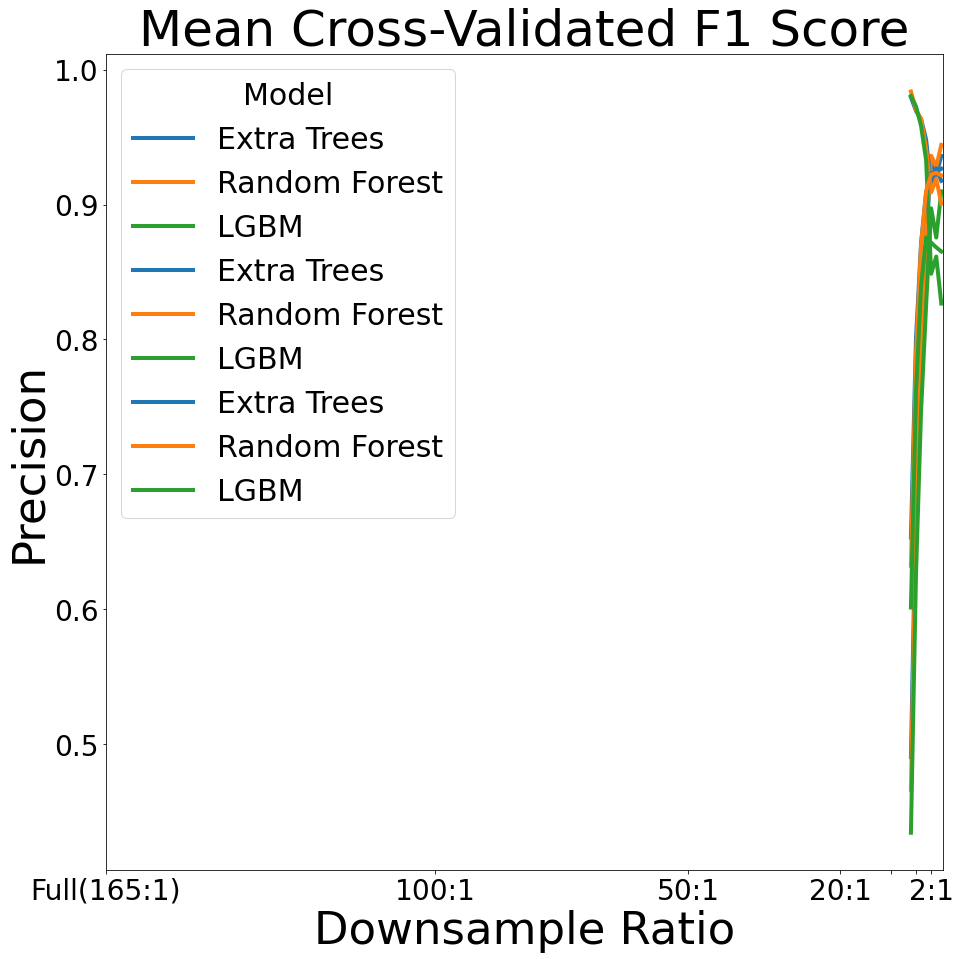

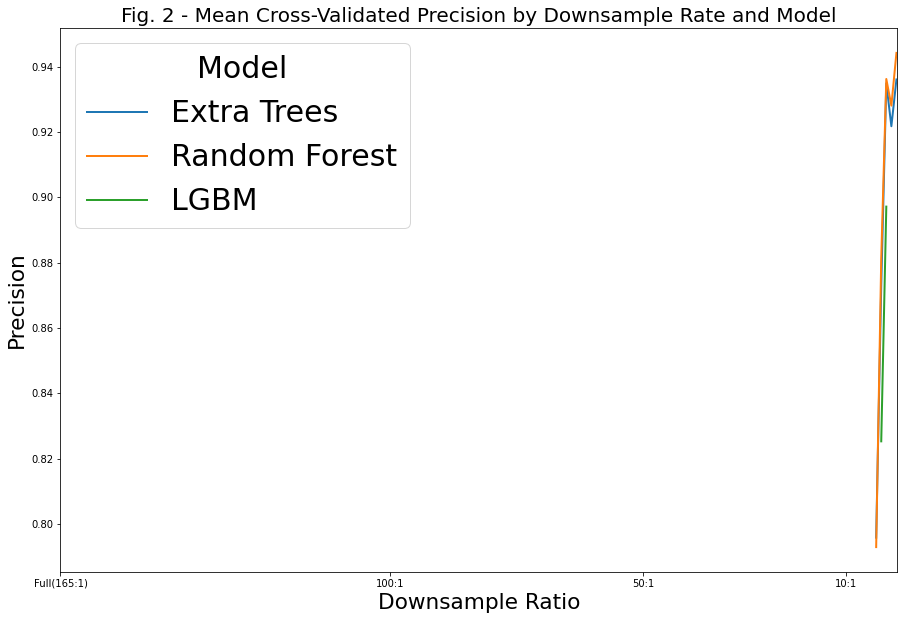

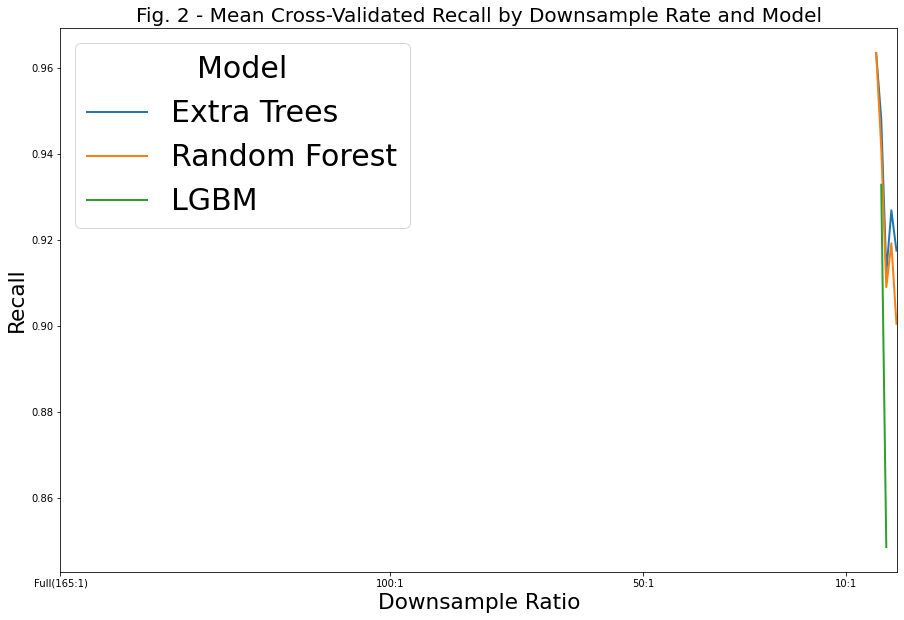

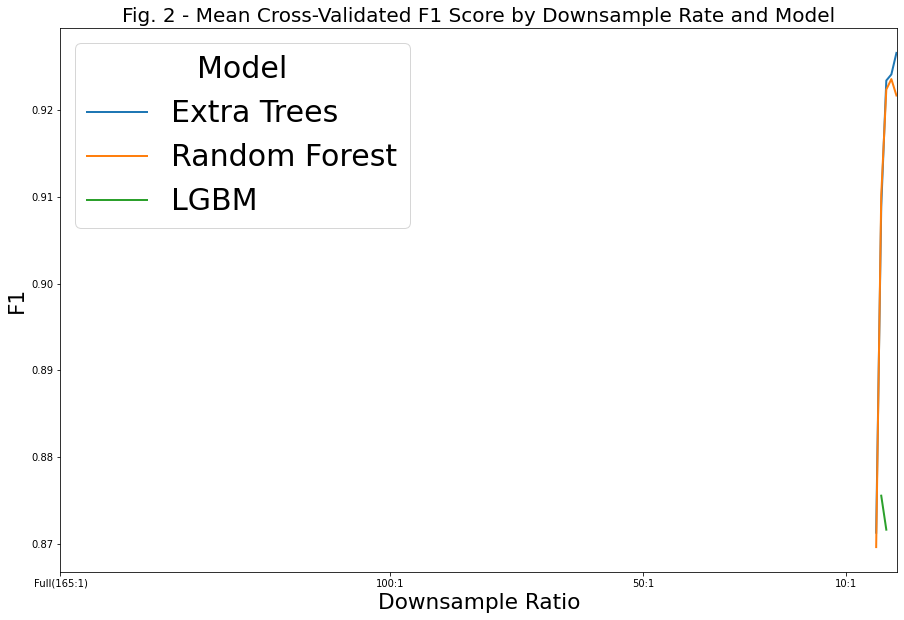

In [82]:
# Mean cross validated precision for GIS
rcParams['figure.figsize']        = 15, 15
rcParams['axes.titlesize']        = 50
rcParams['axes.labelsize']        = 45
rcParams['xtick.labelsize']       = 28
rcParams['ytick.labelsize']       = 28
rcParams['lines.linewidth']       = 4
rcParams['font.size']             = 18
rcParams['legend.fontsize']       = 30
rcParams['legend.title_fontsize'] = 30
ax                                = sns.lineplot(x    = 'Sample', 
                                                 y    = 'Precision', 
                                                 hue  = 'Model', 
                                                 data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Precision')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedPrecision.png')

# Mean cross validated Recall for GIS
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated Recall')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedRecall.png')

# Mean cross validated F1 for GIS
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResults)
ax.invert_xaxis()
ax.set_title('Mean Cross-Validated F1 Score')
ax.set_xticks([165, 100,50,20,10,5,2])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '20:1', '','', '2:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedF1.png')

# Precision by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Precision', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Precision by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedPrecisionByDownsampleRateAndModel.png')

# Recall by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='Recall', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated Recall by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedRecallByDownsampleRateAndModel.png')

# F1 by Downsample Rate and Model
plt.figure(figsize=(15, 10))
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18
ax = sns.lineplot(x='Sample', y='F1', hue='Model', data = crossValResultsShort)
ax.invert_xaxis()
ax.set_title('Fig. 2 - Mean Cross-Validated F1 Score by Downsample Rate and Model')
ax.set_xticks([165, 100,50,10])
ax.set_xticklabels(['Full(165:1)', '100:1', '50:1', '10:1'])
ax.set_xlabel('Downsample Ratio')
plt.savefig(GISFolder + '\\MeanCrossValidatedF1ByDownsampleRateAndModel.png')

End.